Todo: 

* Classifier per hero * role

In [4]:
import os
import json
import numpy as np
import pickle 
import tqdm
import gzip
import tarfile
from scipy import sparse


In [5]:
# with tarfile.open("../data/parsed/opendota_parsed_matches.tar.gz", 'r:gz') as zfp:
#     for filename in zfp.getnames():
#         match = pickle.load(zfp.extractfile(filename))
#         print(match)
#         break

zfp = tarfile.open("../data/opendota_parsed_matches.tar.gz", 'r:gz')
all_filenames = zfp.getnames()

In [6]:
filenames = all_filenames[1:]

In [7]:
# fp = zfp.extractfile(filenames[0])
# fp.seek(0)
# match = pickle.loads(fp.read())

In [17]:
def get_rank(rank: int):
    oh = np.zeros(5)
    oh[rank] = 1
    return oh

def kda(kills, deaths, assists):
    return kills + assists / (deaths + 1)

def extract_data_point(match):
    players = match["players"]
    t0 = list(filter(lambda p: p["isRadiant"], players))
    t1 = list(filter(lambda p: not p["isRadiant"], players))
    xs = []
    ys = []
    for team in [t0, t1]:
        hids = [p["hero_id"] for p in team]

        # !Ranks
        attributes = ["gold_per_min", "xp_per_min", "kills", "deaths", "assists", "last_hits", "hero_damage", "tower_damage"]
        ranks = {}
        
        for attr in attributes:
            ranks[attr] = sorted([(p["hero_id"], p[attr]) for p in team], key=lambda x: x[1], reverse=True)
        
        # Wards
        wards_placed = []
        for p in team:
            item_uses = p["item_uses"]
            c = 0
            if "ward_observer" in item_uses:
                c += item_uses["ward_observer"]
            if "ward_dispenser" in item_uses:
                c += item_uses["ward_dispenser"]
            if "ward_sentry" in item_uses:
                c += item_uses["ward_sentry"]
                
            wards_placed.append((p["hero_id"], c))

        wards_placed = sorted(wards_placed, key=lambda x: x[1], reverse=True)


        # !Add features
        for h in team:
            features = []
            hid = h["hero_id"]
            
            onehot_hero = np.zeros((136))
            onehot_hero[hid] = 1.
            features.append(onehot_hero)

            teammates = np.zeros((136))
            for team_hid in hids:
                if team_hid != hid:
                    teammates[team_hid] = 1.
            
            features.append(teammates)
            
            for rank in ranks: 
                features.append(get_rank(ranks[rank].index((hid, h[rank]))))

            if hid == wards_placed[0][0]:
                y = 5
            else:
                y = h["lane_role"]
            
            # if y in [1,2]:
            xs.append(np.concatenate(features))
            ys.append(y)

            
            # xs.append(np.concatenate(features))
            # ys.append(y)

    return xs, ys

trainingset = []
labels = []

# !Main loop
for fname in tqdm.tqdm(filenames):
    fp = zfp.extractfile(fname)
    fp.seek(0)
    match = pickle.loads(fp.read())
    xs, ys = extract_data_point(match)
    trainingset.append(np.vstack(xs))
    labels.append(ys)

x = np.vstack(trainingset)
y = np.concatenate(labels).ravel()    

100%|██████████| 50000/50000 [03:32<00:00, 235.13it/s]


In [18]:
unique, counts = np.unique(y, return_counts=True)
print(unique, counts)

[1 2 3 4 5] [129843 102994 163782   3381 100000]


<AxesSubplot:ylabel='Frequency'>

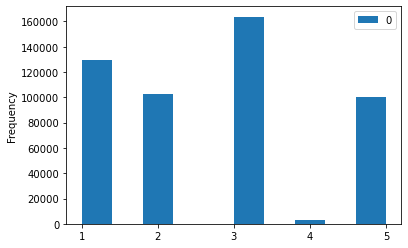

In [19]:
import pandas as pd

df = pd.DataFrame(y)
df.plot.hist(xticks=[1, 2, 3, 4, 5])

In [20]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(np.mean(y_pred == y_test))

print(confusion_matrix(y_test, y_pred))

0.48301
[[13317    90 11663     0   988]
 [ 7251  1334 11918     0   109]
 [ 2047    80 29707     0   977]
 [  221     0   399     0    14]
 [  346    12 15584     0  3943]]


In [21]:
from sklearn.linear_model import LogisticRegression
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
clf = LogisticRegression(random_state=0)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(np.mean(y_pred == y_test))

print(confusion_matrix(y_test, y_pred))

0.72591
[[17761  1283  3215    13  3786]
 [ 1487 16178  2569     2   376]
 [ 1885  2044 24451    20  4411]
 [  260    60   239    34    41]
 [  652   592  4462    12 14167]]


/home/bao/anaconda3/envs/dota/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split


# for hero, train a logistic regression model and add to VotingClassifier
estimators = []


clf = LogisticRegression(multi_class='multinomial', random_state=1)

eclf1 = VotingClassifier(estimators=estimators, voting='hard')
eclf1 = eclf1.fit(x_train, y_train)

ValueError: Invalid 'estimators' attribute, 'estimators' should be a list of (string, estimator) tuples.

In [ ]:
print(eclf1.predict(x_test))

NameError: name 'eclf1' is not defined

In [ ]:
np.array_equal(eclf1.named_estimators_.lr.predict(x), eclf1.named_estimators_['lr'].predict(x))

NameError: name 'np' is not defined